In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import re
import plotly.express as px
import statsmodels.api as sm
import sys
from sqlalchemy import create_engine
import psycopg2
import catboost as catt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [101]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.sort_values(['date','city'],inplace=True)
test.sort_values(['date','city'],inplace=True)

train['date_day'] = train['date'].dt.day_of_year
train['date_month'] = train['date'].dt.month

test['date_day'] = test['date'].dt.day_of_year
test['date_month'] = test['date'].dt.month

x = train[['date_day','pm2_5']].groupby('date_day').aggregate('mean')


In [102]:
city_list = train['city'].unique()
country_list =  train['country'].unique()
print(city_list)
print(country_list)


['Kampala' 'Nairobi' 'Lagos' 'Bujumbura']
['Uganda' 'Kenya' 'Nigeria' 'Burundi']


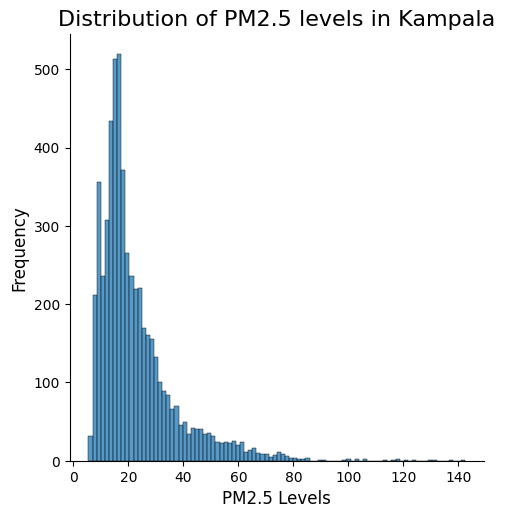

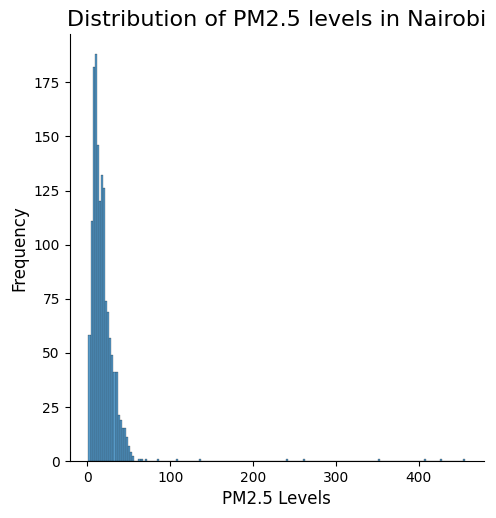

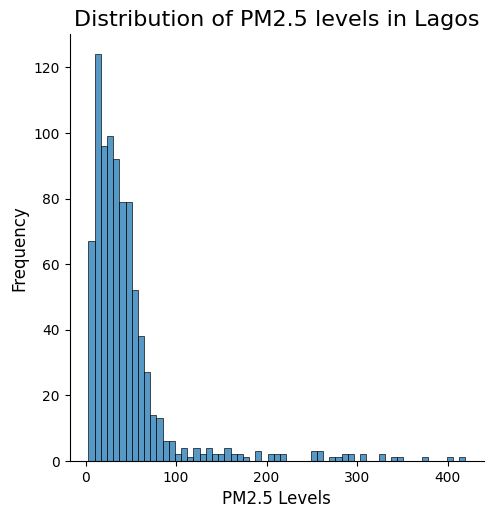

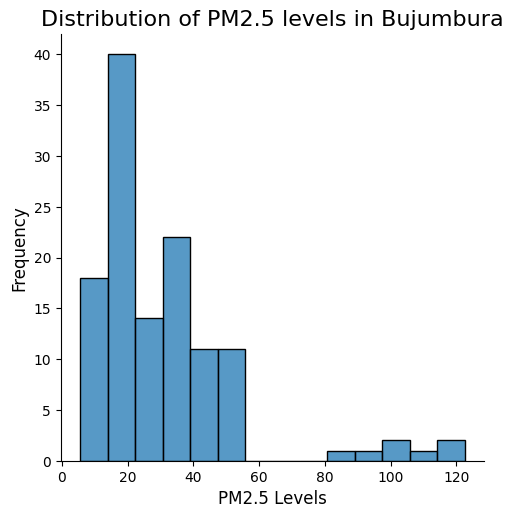

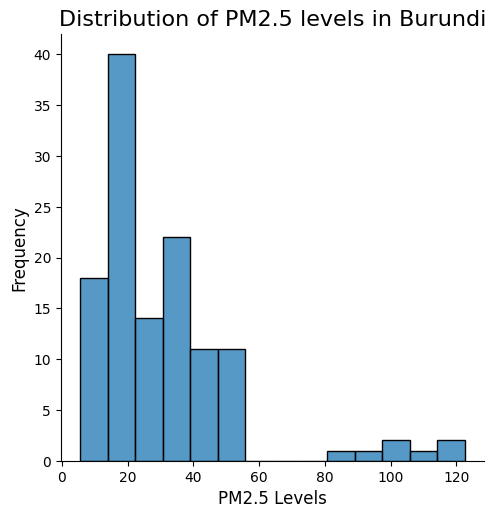

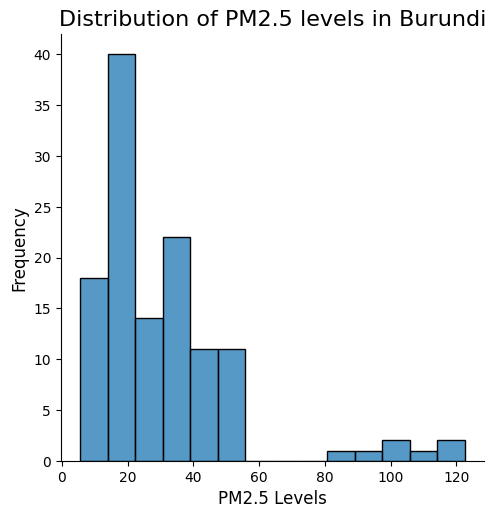

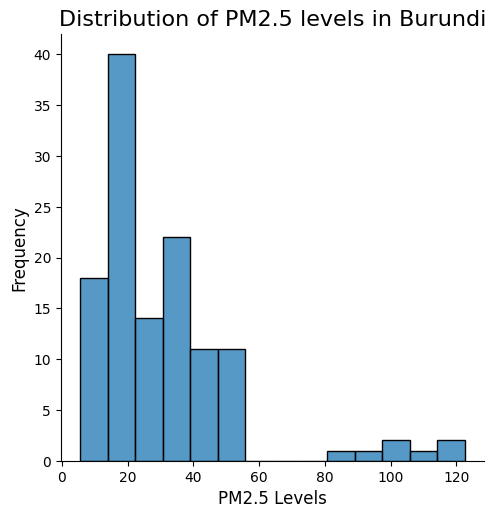

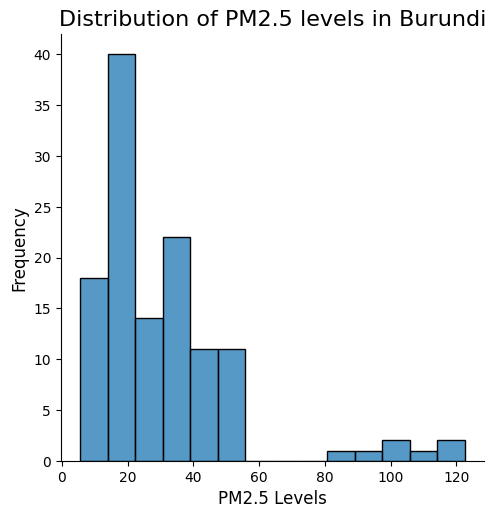

In [103]:
train[train['city']==city_list[0]]['pm2_5']
for i in range(0,len(city_list)):
    sns.displot(train[train['city']==city_list[i]]['pm2_5'])
    plt.title(f'Distribution of PM2.5 levels in {city_list[i]}', fontsize=16)
    plt.xlabel('PM2.5 Levels', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
for j in range(0,len(country_list)):
     sns.displot(train[train['city']==city_list[i]]['pm2_5'])
     plt.title(f'Distribution of PM2.5 levels in {country_list[i]}', fontsize=16)
     plt.xlabel('PM2.5 Levels', fontsize=12)
     plt.ylabel('Frequency', fontsize=12)

<Axes: xlabel='date_day', ylabel='pm2_5'>

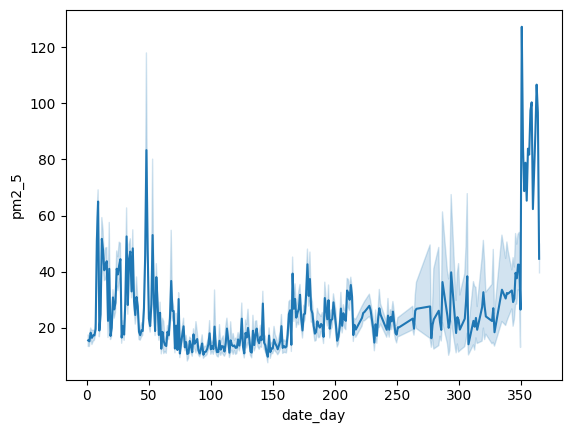

In [104]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

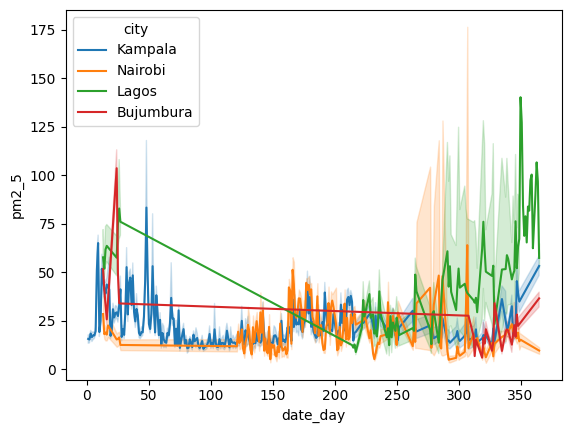

In [105]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['city'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

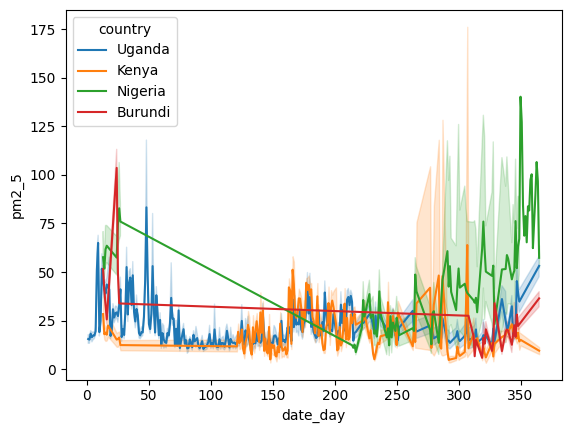

In [106]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['country'])

<Axes: xlabel='date', ylabel='pm2_5'>

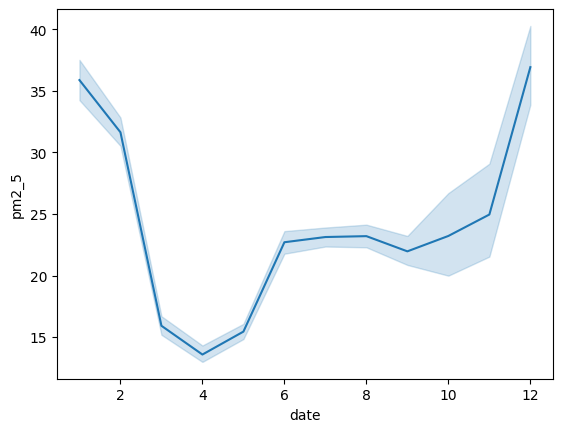

In [107]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'])

<Axes: xlabel='date', ylabel='pm2_5'>

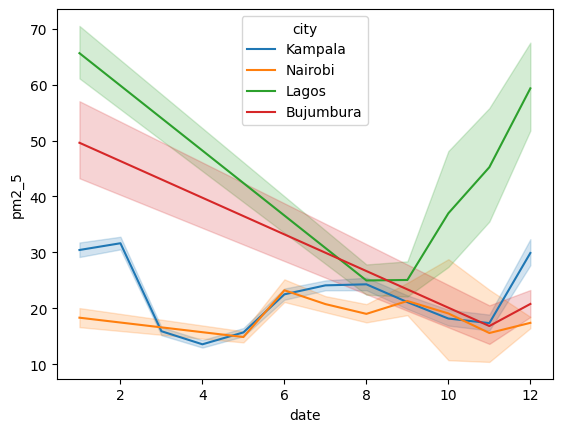

In [108]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'],hue=train['city'])

<Axes: xlabel='hour', ylabel='pm2_5'>

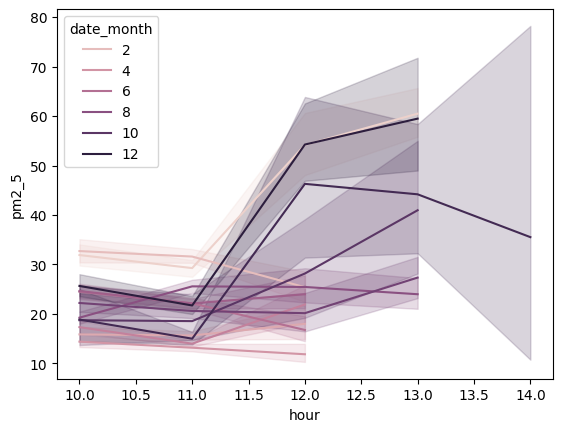

In [109]:
sns.lineplot(x=train['hour'],y=train['pm2_5'],hue=train['date_month'])

<Axes: xlabel='date', ylabel='pm2_5'>

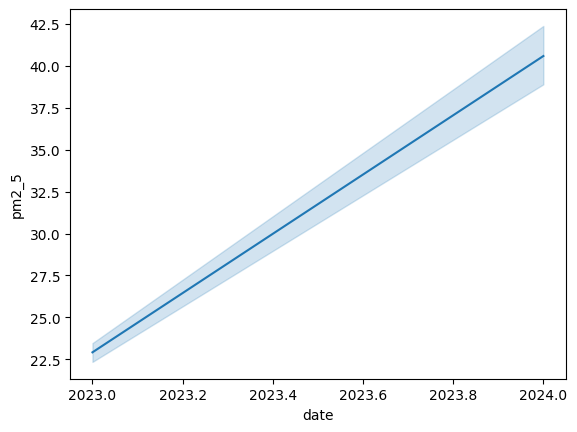

In [110]:
sns.lineplot(x=train['date'].dt.year,y=train['pm2_5'])

<Axes: xlabel='site_latitude', ylabel='site_longitude'>

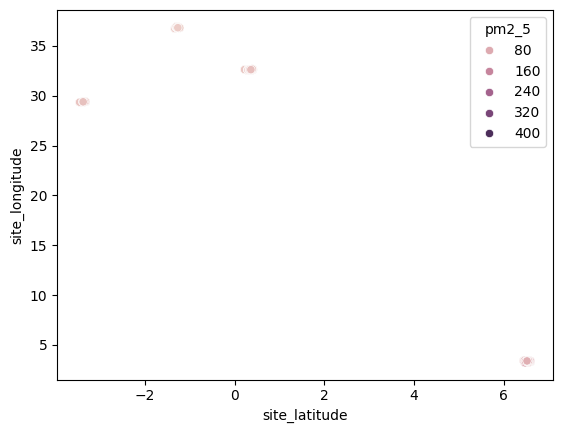

In [111]:
sns.scatterplot(x=train['site_latitude'],y=train['site_longitude'],hue=train['pm2_5'])

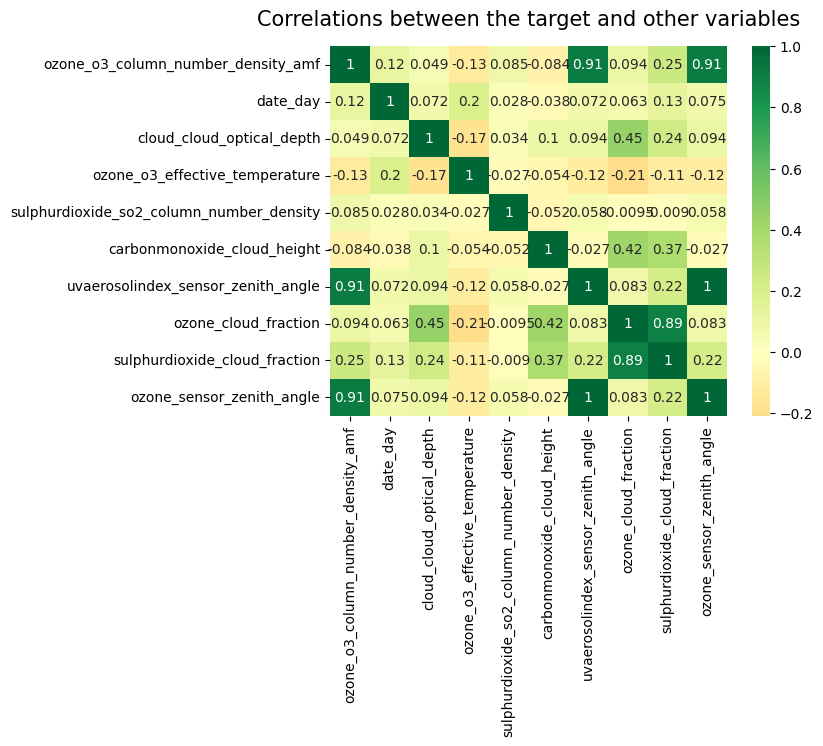

In [112]:
traintest = pd.concat([train,test])
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).tail(10)
# top10_corrs += top10_corrs + train['pm2_5']
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 15})
plt.show()

<Axes: >

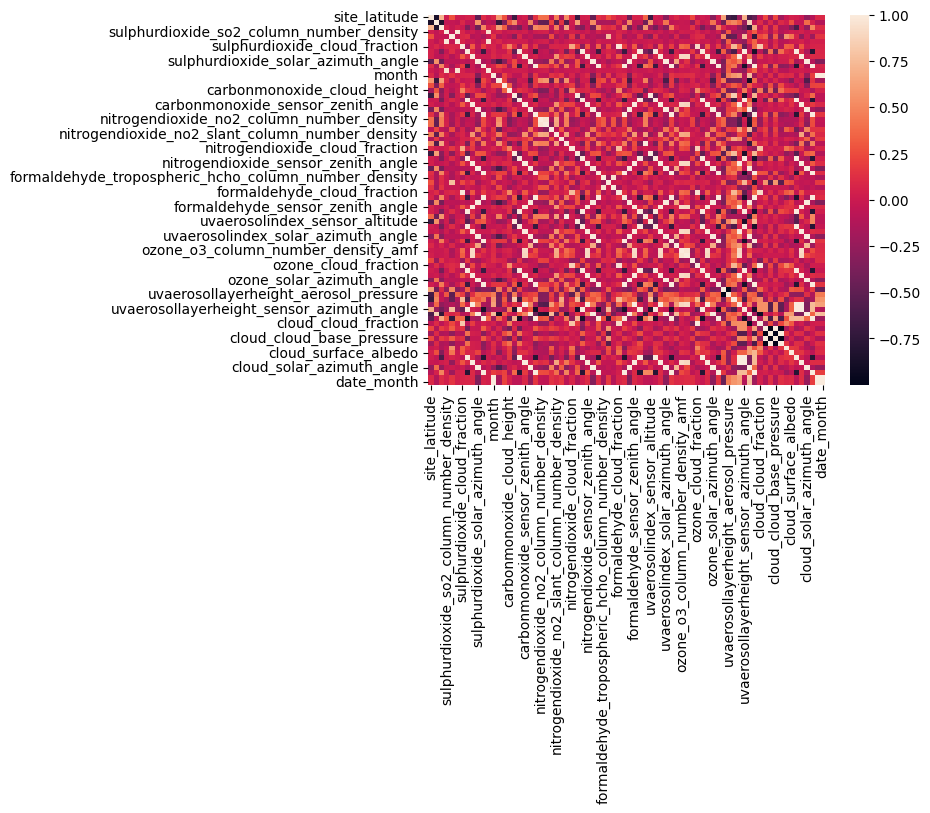

In [113]:
sns.heatmap(test.select_dtypes(include='number').corr(),linewidths=0.0028105)


city
Bujumbura    Axes(0.125,0.11;0.775x0.77)
Kampala      Axes(0.125,0.11;0.775x0.77)
Lagos        Axes(0.125,0.11;0.775x0.77)
Nairobi      Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

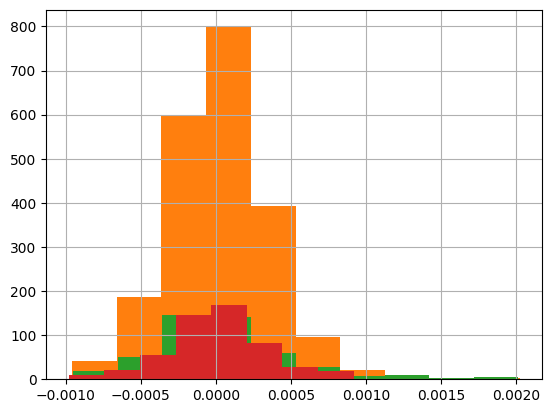

In [114]:
train.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

city
Accra      Axes(0.125,0.11;0.775x0.77)
Gulu       Axes(0.125,0.11;0.775x0.77)
Kisumu     Axes(0.125,0.11;0.775x0.77)
Yaoundé    Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

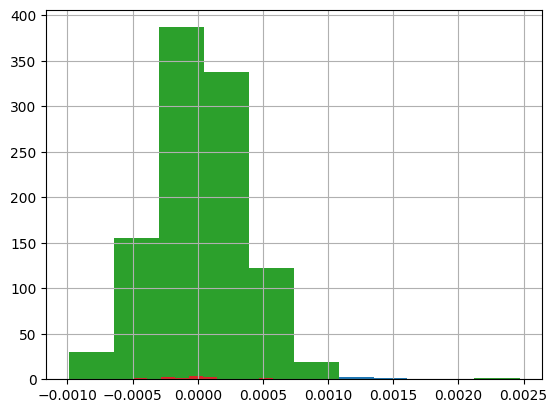

In [115]:
test.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

<Axes: xlabel='cloud_cloud_base_pressure', ylabel='pm2_5'>

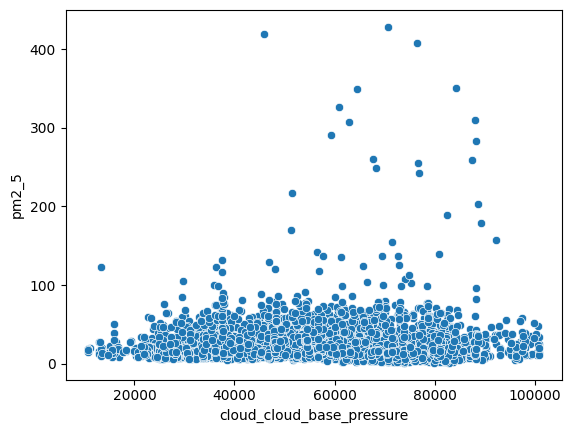

In [116]:
sns.scatterplot(x=train['cloud_cloud_base_pressure'],y=train['pm2_5'])

<Axes: xlabel='sulphurdioxide_so2_column_number_density', ylabel='pm2_5'>

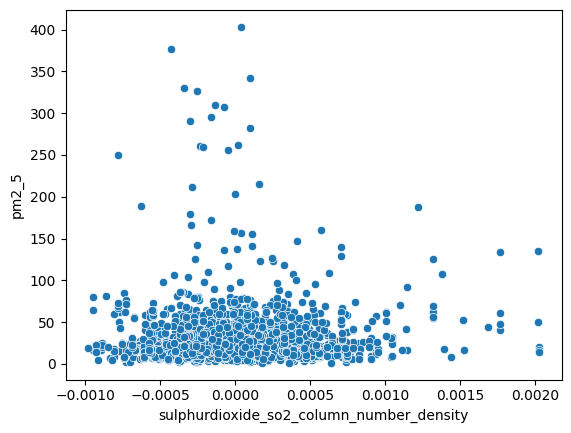

In [117]:
sns.scatterplot(x=train['sulphurdioxide_so2_column_number_density'],y=train['pm2_5'])

In [118]:
train[['pm2_5','nitrogendioxide_no2_slant_column_number_density']].corr()

,pm2_5,nitrogendioxide_no2_slant_column_number_density
pm2_5,1.000000,0.395134
nitrogendioxide_no2_slant_column_number_density,0.395134,1.000000


([<matplotlib.patches.Wedge at 0x2373ac4ffe0>,
 [Text(-0.1910130855889933, 1.083288512416601, ''),
  Text(-0.37622194259509467, -1.0336619611410558, ''),
  Text(0.9526280900645454, -0.5499997472908298, '')])

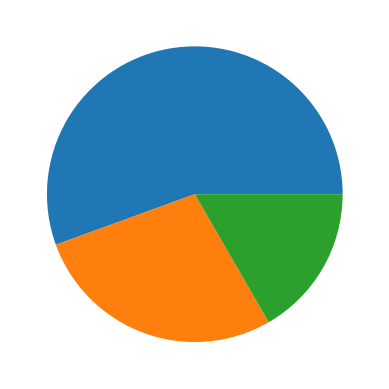

In [119]:
plt.pie([20,10,6])

<Axes: ylabel='hour'>

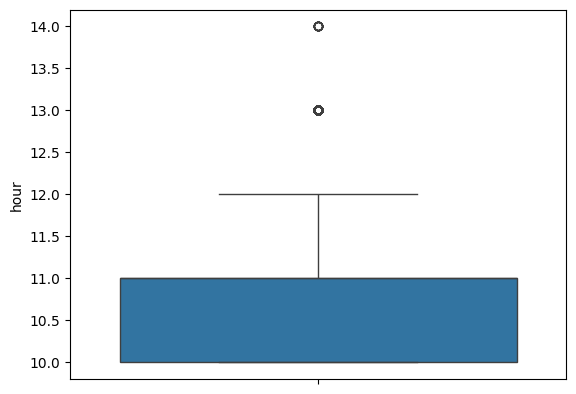

In [120]:
sns.boxplot(train['hour'])

In [121]:
def remove_nans(train, thresh):
    def nans_rate(train, col):
        return train[col].isna().sum() / train.shape[0]
    for col in train.columns:
        if nans_rate(train, col) >= thresh:
            train.drop(col, axis=1, inplace=True)
        else:
            train[col].fillna(method='bfill', inplace=True)
    return train

# Apply NaN handling
train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)
train.shape, test.shape

C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(method='bfill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[col].fillna(method='bfill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: A value is trying to be set on a copy of a Da

((8071, 75), (2783, 74))

In [122]:
def drop_angle_cols(data_set):
    columns_to_drop = [col for col in data_set.columns if 'angle' in col]
    for col in columns_to_drop:
        data_set = data_set.drop(columns=[col])
    return data_set 

train_drop = drop_angle_cols(train)
test_drop = drop_angle_cols(test)
numerical_cols = train_drop.select_dtypes(include = "number").columns

Text(0.5, 1.0, 'Target Distribution')

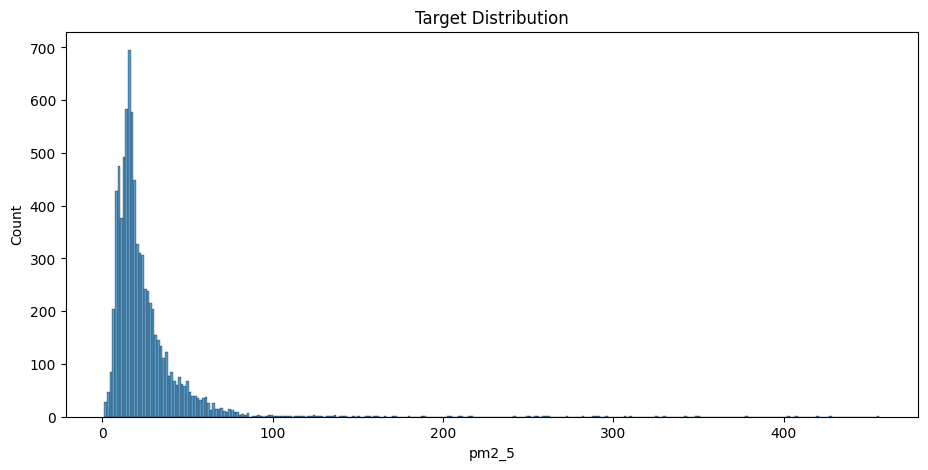

In [123]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train_drop.pm2_5)
plt.title('Target Distribution')

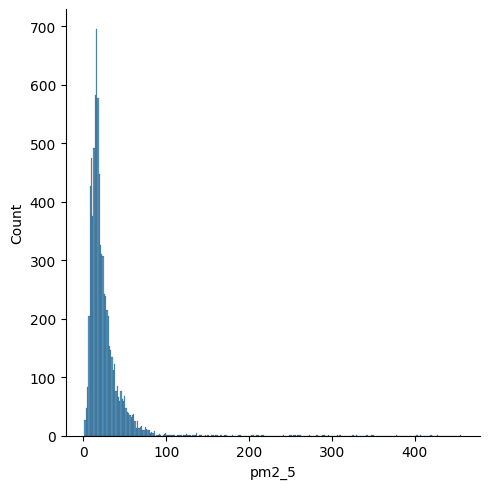

In [124]:
sns.displot((train.pm2_5))

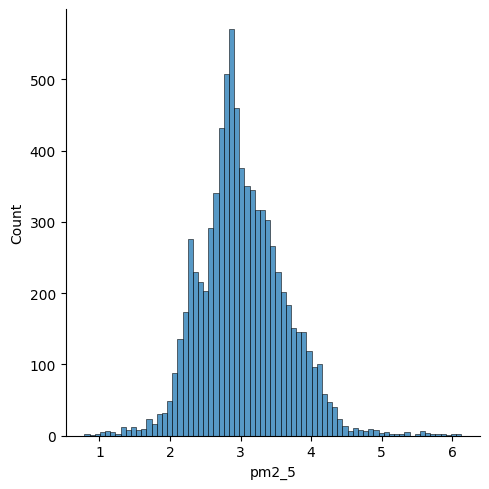

In [125]:
sns.displot(np.log1p(train.pm2_5))

In [126]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 4)
train_drop['folds'] = np.nan

# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train_drop, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train_drop.loc[test_index, 'folds'] = fold

# Convert fold indices to integer type
train_drop['folds'] = train_drop['folds'].astype(int)
train_drop.groupby('folds')['pm2_5'].agg({'count'})

,count
folds,
1,5596
2,1500
3,852
4,123


In [127]:
class Config:
    id_col = "id"
    target_col = "pm2_5"

In [128]:
def feature_engineering(train_drop,test_drop):
    le = LabelEncoder()
     
    data = pd.concat([train_drop, test_drop])
    # capping before feature interactions
    skewed = ['pm2_5','hour']
    data[skewed].describe(percentiles=[0.05,0.95])
    
    #Feature interactions
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data['sulphurdioxide_no2_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['carbonmonoxide_no2_interaction'] = data['carbonmonoxide_co_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['formaldehyde_ozone_interaction'] = data['formaldehyde_tropospheric_hcho_column_number_density'] + data['ozone_o3_column_number_density']
    
    data['sulphurdioxide_cloud_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['cloud_cloud_fraction']
    data['nitrogendioxide_cloud_interaction'] = data['nitrogendioxide_no2_column_number_density'] + data ['cloud_cloud_fraction']
    data['ozone_cloud_interaction'] = data['ozone_o3_column_number_density'] + data['cloud_cloud_fraction']
    
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    #categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='bfill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week
        
        
    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])


#   data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train_drop['id'].unique())]
    test = data[data['id'].isin(test_drop['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train_drop, test_drop)

C:\Users\user\AppData\Local\Temp\ipykernel_8168\3873256015.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='bfill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\3873256015.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[["location","cit

In [129]:
training  = train_df[train_df['folds'].isin([1.0,3.0, 4.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape
((6571, 57), (1500, 57))
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )

Learning rate set to 0.068433
0:	learn: 24.8937005	test: 21.3133739	best: 21.3133739 (0)	total: 22.1ms	remaining: 22.1s
100:	learn: 15.1907751	test: 15.1708080	best: 15.1708080 (100)	total: 1.46s	remaining: 13s
200:	learn: 11.7629632	test: 14.4688720	best: 14.4688720 (200)	total: 2.66s	remaining: 10.6s
300:	learn: 9.8848030	test: 14.2552996	best: 14.2542158 (299)	total: 4.27s	remaining: 9.92s
400:	learn: 8.7456230	test: 14.0784879	best: 14.0784879 (400)	total: 5.46s	remaining: 8.16s
500:	learn: 7.8513236	test: 14.0260045	best: 14.0205431 (484)	total: 7.1s	remaining: 7.07s
600:	learn: 7.1452852	test: 13.9007360	best: 13.8996301 (593)	total: 8.71s	remaining: 5.79s
700:	learn: 6.6447861	test: 13.7903752	best: 13.7903752 (700)	total: 10.3s	remaining: 4.39s
800:	learn: 6.2157224	test: 13.7345412	best: 13.7192677 (720)	total: 11.6s	remaining: 2.87s
900:	learn: 5.8582671	test: 13.7076621	best: 13.7076621 (900)	total: 13.1s	remaining: 1.44s
999:	learn: 5.5374425	test: 13.6318330	best: 13.63158

In [130]:
def get_catt_varimp(model, train_columns, max_vars=350):

    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
40,location,48.61908
0,date,3.929557
8,carbonmonoxide_co_column_number_density,3.723163
42,carbonmonoxide_no2_interaction,3.448941
37,cloud_surface_albedo,2.547406
9,carbonmonoxide_h2o_column_number_density,2.281022
30,ozone_cloud_fraction,2.007101
24,uvaerosolindex_absorbing_aerosol_index,1.67297
50,week,1.487889
25,uvaerosolindex_sensor_altitude,1.479743


In [131]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

array(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction',
       'nitrogendioxide_sensor_altitude',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density

In [132]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.75:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]


In [133]:
from sklearn.preprocessing import StandardScaler

In [134]:
import optuna
# Define the objective function for Optuna
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }
    
    rmse_folds = []
    
    for fold in [1, 2, 3, 4]:
        print("*" * 100)
        df_train = train_df.copy()
        df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

        training = df_train[train_df['folds'] != fold]
        validation = df_train[df_train['folds'] == fold]

        # Training and evaluation
        y_train = training[dependent_feature]
        y_test = validation[dependent_feature]

        X_train = training[selected_columns]
        X_test = validation[selected_columns]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
        preds = model.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_folds.append(rmse)

    return np.mean(rmse_folds)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

# Train and evaluate the model using the best parameters
fold_pred = []
oof_pred = []

for fold in [1, 2, 3, 4]:
    print("*" * 100)
    df_train = train_df.copy()
    df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

    training = df_train[train_df['folds'] != fold]
    validation = df_train[df_train['folds'] == fold]

    # Training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print(f"RMSE for fold {fold} with best params: {rmse}")
    oof_pred.append(rmse)

    # Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)

print(f"The average RMSE across the 4 groups: {np.mean(oof_pred)}")

[I 2024-06-24 15:47:41,107] A new study created in memory with name: no-name-b4885aee-db4a-45cf-a543-3558acf0f082
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:47:43,550] Trial 0 finished with value: 7.571972089482845 and parameters: {'num_leaves': 32, 'learning_rate': 0.07053742640403857, 'n_estimators': 212, 'min_child_samples': 38, 'subsample': 0.9678621119652431, 'colsample_bytree': 0.7113144180135911, 'reg_alpha': 0.14461738491504617, 'reg_lambda': 0.43412126604152446}. Best is trial 0 with value: 7.571972089482845.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:47:48,664] Trial 1 finished with value: 7.665388558117355 and parameters: {'num_leaves': 47, 'learning_rate': 0.02884260700566024, 'n_estimators': 350, 'min_child_samples': 72, 'subsample': 0.9424074216684456, 'colsample_bytree': 0.7001120869024838, 'reg_alpha': 0.32376664373295294, 'reg_lambda': 0.11454555806488442}. Best is trial 0 with value: 7.571972089482845.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:47:56,381] Trial 2 finished with value: 7.967342138799628 and parameters: {'num_leaves': 51, 'learning_rate': 0.011677145113120544, 'n_estimators': 483, 'min_child_samples': 70, 'subsample': 0.900291009524649, 'colsample_bytree': 0.718833186723981, 'reg_alpha': 0.1813444483603378, 'reg_lambda': 0.6420615642719911}. Best is trial 0 with value: 7.571972089482845.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rat

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:05,561] Trial 3 finished with value: 7.448277088527326 and parameters: {'num_leaves': 41, 'learning_rate': 0.08937227513452844, 'n_estimators': 561, 'min_child_samples': 74, 'subsample': 0.8560339993483379, 'colsample_bytree': 0.9893029981807581, 'reg_alpha': 0.20421791885225093, 'reg_lambda': 0.9573573467853874}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:07,662] Trial 4 finished with value: 9.355422751781255 and parameters: {'num_leaves': 31, 'learning_rate': 0.014717039720290323, 'n_estimators': 139, 'min_child_samples': 56, 'subsample': 0.7554066733845407, 'colsample_bytree': 0.9891221331792055, 'reg_alpha': 0.729692429876228, 'reg_lambda': 0.607214488974843}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rat

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:14,547] Trial 5 finished with value: 8.177323988201552 and parameters: {'num_leaves': 66, 'learning_rate': 0.013785163386188905, 'n_estimators': 343, 'min_child_samples': 78, 'subsample': 0.7234595578356371, 'colsample_bytree': 0.8728641335913885, 'reg_alpha': 0.30924399523631585, 'reg_lambda': 0.5098498793348826}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:28,802] Trial 6 finished with value: 7.462256170249079 and parameters: {'num_leaves': 33, 'learning_rate': 0.013664239196962951, 'n_estimators': 930, 'min_child_samples': 26, 'subsample': 0.7473584833545917, 'colsample_bytree': 0.9227270862250208, 'reg_alpha': 0.6037298337389216, 'reg_lambda': 0.38860845519937115}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:31,431] Trial 7 finished with value: 8.11485560761273 and parameters: {'num_leaves': 49, 'learning_rate': 0.03810135778134072, 'n_estimators': 189, 'min_child_samples': 93, 'subsample': 0.9670340918432483, 'colsample_bytree': 0.7707368171386493, 'reg_alpha': 0.3135084346889758, 'reg_lambda': 0.6053432909193573}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rat

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:47,257] Trial 8 finished with value: 7.484734043848979 and parameters: {'num_leaves': 64, 'learning_rate': 0.04598411611537962, 'n_estimators': 773, 'min_child_samples': 96, 'subsample': 0.9342398023204848, 'colsample_bytree': 0.9496623570995173, 'reg_alpha': 0.16707936765375309, 'reg_lambda': 0.10306395744297969}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:48:59,340] Trial 9 finished with value: 7.916648255958129 and parameters: {'num_leaves': 46, 'learning_rate': 0.013131043697283008, 'n_estimators': 774, 'min_child_samples': 95, 'subsample': 0.9284230210993241, 'colsample_bytree': 0.7167505404179917, 'reg_alpha': 0.9685153008780958, 'reg_lambda': 0.8651291796887582}. Best is trial 3 with value: 7.448277088527326.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:49:09,088] Trial 10 finished with value: 7.3710352521269416 and parameters: {'num_leaves': 41, 'learning_rate': 0.08781264894446986, 'n_estimators': 596, 'min_child_samples': 53, 'subsample': 0.8261074400051696, 'colsample_bytree': 0.8206477431084029, 'reg_alpha': 0.012698758559917644, 'reg_lambda': 0.9928117532324464}. Best is trial 10 with value: 7.3710352521269416.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learn

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:49:19,305] Trial 11 finished with value: 7.32018268472492 and parameters: {'num_leaves': 41, 'learning_rate': 0.09996888282499614, 'n_estimators': 620, 'min_child_samples': 53, 'subsample': 0.8240591887174369, 'colsample_bytree': 0.8174145225159429, 'reg_alpha': 0.002900323012040684, 'reg_lambda': 0.9950237288937857}. Best is trial 11 with value: 7.32018268472492.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:49:30,363] Trial 12 finished with value: 7.302819098633235 and parameters: {'num_leaves': 40, 'learning_rate': 0.09464024324306693, 'n_estimators': 630, 'min_child_samples': 46, 'subsample': 0.8106484443454651, 'colsample_bytree': 0.8165626475327236, 'reg_alpha': 0.012310624715303767, 'reg_lambda': 0.8188410331016083}. Best is trial 12 with value: 7.302819098633235.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:49:47,669] Trial 13 finished with value: 7.283903182294626 and parameters: {'num_leaves': 57, 'learning_rate': 0.05738590594258036, 'n_estimators': 704, 'min_child_samples': 43, 'subsample': 0.8152247634335141, 'colsample_bytree': 0.8246160087149281, 'reg_alpha': 0.00843136402704742, 'reg_lambda': 0.7998539978054977}. Best is trial 13 with value: 7.283903182294626.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:50:04,836] Trial 14 finished with value: 7.235101263330641 and parameters: {'num_leaves': 58, 'learning_rate': 0.05699918484138796, 'n_estimators': 739, 'min_child_samples': 39, 'subsample': 0.7851193057034666, 'colsample_bytree': 0.8685227182220334, 'reg_alpha': 0.4165161416380076, 'reg_lambda': 0.7948371468848335}. Best is trial 14 with value: 7.235101263330641.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:50:24,048] Trial 15 finished with value: 7.1251820081381725 and parameters: {'num_leaves': 58, 'learning_rate': 0.05157492283767031, 'n_estimators': 800, 'min_child_samples': 23, 'subsample': 0.7811039302787377, 'colsample_bytree': 0.8808646556475356, 'reg_alpha': 0.5047183518933949, 'reg_lambda': 0.7608264267127883}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:50:48,671] Trial 16 finished with value: 7.134746601297477 and parameters: {'num_leaves': 59, 'learning_rate': 0.025338170695281482, 'n_estimators': 976, 'min_child_samples': 20, 'subsample': 0.7745048988891101, 'colsample_bytree': 0.8849358299920969, 'reg_alpha': 0.5051678048348751, 'reg_lambda': 0.7437555048374552}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:51:32,610] Trial 17 finished with value: 7.172007210992606 and parameters: {'num_leaves': 60, 'learning_rate': 0.024078931236267444, 'n_estimators': 996, 'min_child_samples': 21, 'subsample': 0.7024272980306295, 'colsample_bytree': 0.9104990351814493, 'reg_alpha': 0.5847158865828492, 'reg_lambda': 0.6909345048336616}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:51:54,811] Trial 18 finished with value: 7.230445257141484 and parameters: {'num_leaves': 69, 'learning_rate': 0.02005772183933786, 'n_estimators': 883, 'min_child_samples': 30, 'subsample': 0.7739989756743452, 'colsample_bytree': 0.8946184620626, 'reg_alpha': 0.7724611548247392, 'reg_lambda': 0.3630399236805202}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:52:12,632] Trial 19 finished with value: 7.165179081282924 and parameters: {'num_leaves': 54, 'learning_rate': 0.034591649103397425, 'n_estimators': 856, 'min_child_samples': 20, 'subsample': 0.8678335306385943, 'colsample_bytree': 0.9462779916637715, 'reg_alpha': 0.4968029502142251, 'reg_lambda': 0.7203166545351847}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:52:32,378] Trial 20 finished with value: 7.209847383679661 and parameters: {'num_leaves': 62, 'learning_rate': 0.02150014302508227, 'n_estimators': 994, 'min_child_samples': 32, 'subsample': 0.7910400466691215, 'colsample_bytree': 0.7876008177975322, 'reg_alpha': 0.7467632288781556, 'reg_lambda': 0.24665098641399652}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:52:52,379] Trial 21 finished with value: 7.147612031010681 and parameters: {'num_leaves': 54, 'learning_rate': 0.03609993453193182, 'n_estimators': 852, 'min_child_samples': 21, 'subsample': 0.863096695499987, 'colsample_bytree': 0.9504045481154147, 'reg_alpha': 0.4924864176017253, 'reg_lambda': 0.7150214288973165}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:53:14,983] Trial 22 finished with value: 7.205377777110996 and parameters: {'num_leaves': 54, 'learning_rate': 0.04180992458150167, 'n_estimators': 868, 'min_child_samples': 28, 'subsample': 0.8910496652162537, 'colsample_bytree': 0.9391820973219885, 'reg_alpha': 0.47230715567208015, 'reg_lambda': 0.5222836213604832}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:53:49,820] Trial 23 finished with value: 7.269657159534059 and parameters: {'num_leaves': 55, 'learning_rate': 0.0288443751664034, 'n_estimators': 815, 'min_child_samples': 35, 'subsample': 0.841440824609284, 'colsample_bytree': 0.8873778827795374, 'reg_alpha': 0.6212368846290787, 'reg_lambda': 0.889270397296795}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:55:02,968] Trial 24 finished with value: 7.1253608387047995 and parameters: {'num_leaves': 60, 'learning_rate': 0.05108775084808456, 'n_estimators': 932, 'min_child_samples': 20, 'subsample': 0.7392769940798731, 'colsample_bytree': 0.8525600426540116, 'reg_alpha': 0.4117716874439679, 'reg_lambda': 0.7395464134413587}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:55:27,504] Trial 25 finished with value: 7.1374456717124986 and parameters: {'num_leaves': 70, 'learning_rate': 0.05064755830391542, 'n_estimators': 934, 'min_child_samples': 26, 'subsample': 0.7357542900085798, 'colsample_bytree': 0.8550202983598718, 'reg_alpha': 0.41540387944567125, 'reg_lambda': 0.7443258375947321}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learni

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:55:41,501] Trial 26 finished with value: 7.2576644977906515 and parameters: {'num_leaves': 61, 'learning_rate': 0.07114182504105036, 'n_estimators': 674, 'min_child_samples': 48, 'subsample': 0.7040601252480686, 'colsample_bytree': 0.846427458557628, 'reg_alpha': 0.691058681193458, 'reg_lambda': 0.8912318489664618}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:56:02,392] Trial 27 finished with value: 7.297732488775447 and parameters: {'num_leaves': 66, 'learning_rate': 0.017317432850972113, 'n_estimators': 929, 'min_child_samples': 34, 'subsample': 0.7724131420330675, 'colsample_bytree': 0.7859093086299382, 'reg_alpha': 0.8410161071795476, 'reg_lambda': 0.5859723209644196}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:56:13,287] Trial 28 finished with value: 7.164223231929363 and parameters: {'num_leaves': 58, 'learning_rate': 0.06431775582432986, 'n_estimators': 452, 'min_child_samples': 25, 'subsample': 0.797536632130919, 'colsample_bytree': 0.8406901282350652, 'reg_alpha': 0.38531714799375827, 'reg_lambda': 0.7779237417891767}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:56:35,495] Trial 29 finished with value: 7.303731041848216 and parameters: {'num_leaves': 64, 'learning_rate': 0.026072816434487354, 'n_estimators': 952, 'min_child_samples': 39, 'subsample': 0.7602413192844449, 'colsample_bytree': 0.8979779442604521, 'reg_alpha': 0.5688300979744934, 'reg_lambda': 0.6771391218640163}. Best is trial 15 with value: 7.1251820081381725.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:56:51,584] Trial 30 finished with value: 7.118424661467484 and parameters: {'num_leaves': 51, 'learning_rate': 0.04583213023931675, 'n_estimators': 799, 'min_child_samples': 20, 'subsample': 0.7312896211737985, 'colsample_bytree': 0.8792318120630083, 'reg_alpha': 0.2611321699840301, 'reg_lambda': 0.009638130648710774}. Best is trial 30 with value: 7.118424661467484.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:57:08,440] Trial 31 finished with value: 7.148782765616221 and parameters: {'num_leaves': 51, 'learning_rate': 0.04780842755714333, 'n_estimators': 831, 'min_child_samples': 20, 'subsample': 0.723825956485999, 'colsample_bytree': 0.8753742072577755, 'reg_alpha': 0.2689057037417432, 'reg_lambda': 0.014615529750685696}. Best is trial 30 with value: 7.118424661467484.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:57:22,992] Trial 32 finished with value: 7.204070542030305 and parameters: {'num_leaves': 45, 'learning_rate': 0.07437339645105252, 'n_estimators': 786, 'min_child_samples': 29, 'subsample': 0.7335110595234485, 'colsample_bytree': 0.9126365155280713, 'reg_alpha': 0.37088562290492266, 'reg_lambda': 0.28372739344361164}. Best is trial 30 with value: 7.118424661467484.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:57:41,453] Trial 33 finished with value: 7.064854683247039 and parameters: {'num_leaves': 56, 'learning_rate': 0.04114761125945252, 'n_estimators': 901, 'min_child_samples': 25, 'subsample': 0.7615587870421068, 'colsample_bytree': 0.8614042393312871, 'reg_alpha': 0.22638704001275947, 'reg_lambda': 0.45179850221900486}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:57:54,174] Trial 34 finished with value: 7.314897632991309 and parameters: {'num_leaves': 51, 'learning_rate': 0.05450837136770254, 'n_estimators': 708, 'min_child_samples': 62, 'subsample': 0.7451788876363987, 'colsample_bytree': 0.8583486620573616, 'reg_alpha': 0.11202543166958076, 'reg_lambda': 0.24745021279546403}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:58:11,240] Trial 35 finished with value: 7.270136007480927 and parameters: {'num_leaves': 49, 'learning_rate': 0.04202963959129978, 'n_estimators': 884, 'min_child_samples': 36, 'subsample': 0.7186227605531829, 'colsample_bytree': 0.8436498692496439, 'reg_alpha': 0.23290857714233512, 'reg_lambda': 0.10798630637255735}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:58:20,308] Trial 36 finished with value: 7.6342140134137955 and parameters: {'num_leaves': 52, 'learning_rate': 0.030291867555452292, 'n_estimators': 534, 'min_child_samples': 88, 'subsample': 0.764512993534754, 'colsample_bytree': 0.7434527297211116, 'reg_alpha': 0.10953409591262742, 'reg_lambda': 0.4393284492567923}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:58:28,456] Trial 37 finished with value: 7.190474014211784 and parameters: {'num_leaves': 56, 'learning_rate': 0.063004797560658, 'n_estimators': 314, 'min_child_samples': 25, 'subsample': 0.7491105880687089, 'colsample_bytree': 0.9263981475570421, 'reg_alpha': 0.2598347868457296, 'reg_lambda': 0.020691116519909736}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:58:47,509] Trial 38 finished with value: 7.2177387793678385 and parameters: {'num_leaves': 62, 'learning_rate': 0.040281690893898034, 'n_estimators': 905, 'min_child_samples': 66, 'subsample': 0.7183638814332588, 'colsample_bytree': 0.7987867365374124, 'reg_alpha': 0.35171208289592093, 'reg_lambda': 0.46186310137204234}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learn

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:59:02,755] Trial 39 finished with value: 7.215737013079983 and parameters: {'num_leaves': 48, 'learning_rate': 0.07799351369812592, 'n_estimators': 737, 'min_child_samples': 31, 'subsample': 0.7891317286568451, 'colsample_bytree': 0.9720581291956211, 'reg_alpha': 0.20219320934918597, 'reg_lambda': 0.5514375537881947}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:59:20,310] Trial 40 finished with value: 7.596701451743505 and parameters: {'num_leaves': 53, 'learning_rate': 0.010257586959492226, 'n_estimators': 810, 'min_child_samples': 41, 'subsample': 0.7392365915699974, 'colsample_bytree': 0.8646858416693527, 'reg_alpha': 0.4372604932715891, 'reg_lambda': 0.640756715587782}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:59:41,650] Trial 41 finished with value: 7.177733344706489 and parameters: {'num_leaves': 58, 'learning_rate': 0.033147947941169986, 'n_estimators': 964, 'min_child_samples': 23, 'subsample': 0.7617567620532582, 'colsample_bytree': 0.8851193863208461, 'reg_alpha': 0.5559253961255812, 'reg_lambda': 0.3403111404251229}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:00:02,981] Trial 42 finished with value: 7.144200868013579 and parameters: {'num_leaves': 59, 'learning_rate': 0.04521935518271923, 'n_estimators': 915, 'min_child_samples': 24, 'subsample': 0.7774723523719818, 'colsample_bytree': 0.8778074290941669, 'reg_alpha': 0.3251855445278844, 'reg_lambda': 0.6334583720477959}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:00:43,947] Trial 43 finished with value: 7.196593183831504 and parameters: {'num_leaves': 64, 'learning_rate': 0.05002431589781202, 'n_estimators': 971, 'min_child_samples': 28, 'subsample': 0.7493358353167303, 'colsample_bytree': 0.8343310154167566, 'reg_alpha': 0.651492895497767, 'reg_lambda': 0.8449076454455656}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:01:04,397] Trial 44 finished with value: 7.17144804879647 and parameters: {'num_leaves': 56, 'learning_rate': 0.03772684280673252, 'n_estimators': 763, 'min_child_samples': 20, 'subsample': 0.9905620428194187, 'colsample_bytree': 0.8999655557192953, 'reg_alpha': 0.5370978969973723, 'reg_lambda': 0.1734888747211937}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:01:30,310] Trial 45 finished with value: 7.186177146751941 and parameters: {'num_leaves': 60, 'learning_rate': 0.03128433492692458, 'n_estimators': 822, 'min_child_samples': 33, 'subsample': 0.7276093356811414, 'colsample_bytree': 0.8592475829272491, 'reg_alpha': 0.12961435560483758, 'reg_lambda': 0.7519086484949993}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:02:06,582] Trial 46 finished with value: 7.128914294723474 and parameters: {'num_leaves': 43, 'learning_rate': 0.06369240656744413, 'n_estimators': 890, 'min_child_samples': 24, 'subsample': 0.7117322440296341, 'colsample_bytree': 0.9097902383818345, 'reg_alpha': 0.2788060484904552, 'reg_lambda': 0.9366128838516117}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:02:22,381] Trial 47 finished with value: 7.398598603321581 and parameters: {'num_leaves': 35, 'learning_rate': 0.06165210219453844, 'n_estimators': 652, 'min_child_samples': 75, 'subsample': 0.8054285334593799, 'colsample_bytree': 0.9157335501298686, 'reg_alpha': 0.28368321538168645, 'reg_lambda': 0.9455451804040225}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:02:44,952] Trial 48 finished with value: 7.113511225112047 and parameters: {'num_leaves': 38, 'learning_rate': 0.052173212595351744, 'n_estimators': 899, 'min_child_samples': 26, 'subsample': 0.7115843162198462, 'colsample_bytree': 0.9303888786781106, 'reg_alpha': 0.0826036029419232, 'reg_lambda': 0.9336815821822627}. Best is trial 33 with value: 7.064854683247039.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 16:02:55,262] Trial 49 finished with value: 7.246486114948383 and parameters: {'num_leaves': 36, 'learning_rate': 0.053396570191105226, 'n_estimators': 561, 'min_child_samples': 28, 'subsample': 0.710964287901838, 'colsample_bytree': 0.9649837841953252, 'reg_alpha': 0.07401054654953321, 'reg_lambda': 0.15283777194275397}. Best is trial 33 with value: 7.064854683247039.


Best hyperparameters found by Optuna:
{'num_leaves': 56, 'learning_rate': 0.04114761125945252, 'n_estimators': 901, 'min_child_samples': 25, 'subsample': 0.7615587870421068, 'colsample_bytree': 0.8614042393312871, 'reg_alpha': 0.22638704001275947, 'reg_lambda': 0.45179850221900486}
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 1 with best params: 10.026735067881955
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 2 with best params: 7.201034409841302
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 3 with best params: 6.280459637299408
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806
RMSE for fold 4 with best params: 4.899479311669736
The average RMSE across the 4 groups: 7.1019271066731005


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

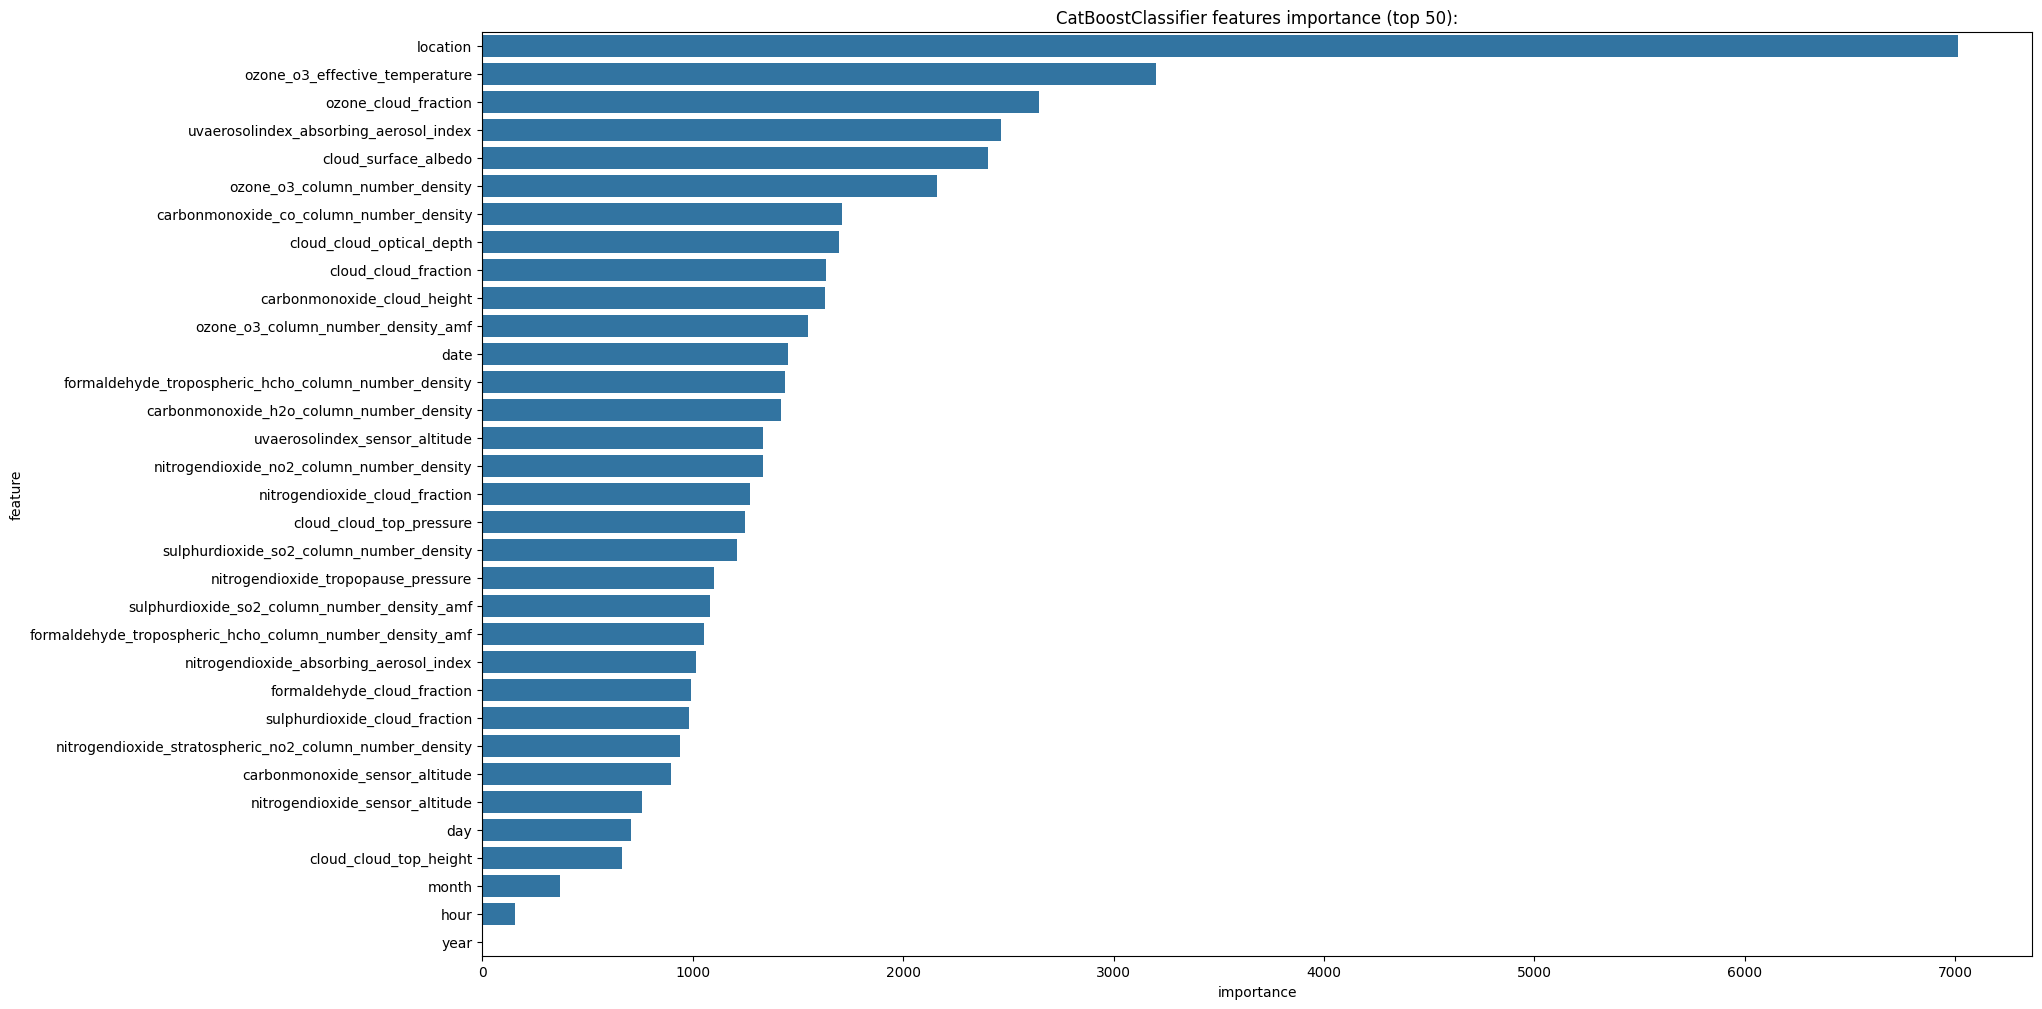

In [135]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

In [136]:
pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()

,id,pred
214,id_yorywxet0a,18.739785
215,id_9rhbkh8kye,15.632317
216,id_oh2pg7ik9m,15.547223
217,id_u5xtrnbshq,17.757910
218,id_pfcdhqpggy,18.332146


In [137]:
sub.to_csv('submit64.csv', index= False)